# Assignment

In [1]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 3 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 2 0 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  3

[[0 0 3 0]
 [0 0 0 0]
 [0 0 1 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=100000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.20253 Number of steps:  7.00923


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

################## INITALISE YOUR NEURAL NETWORK.########################################
#Epsilon_Greedy Policy. Filter for the valid ones.
#https://keras.io/examples/rl/deep_q_network_breakout/

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon
    if rand_a==True:
        a,_=np.where(allowed_a==1)
        return np.random.permutation(a)[0]
    else:#
        Qvalues = Qvalues.numpy()
        #set the qvalues for not allowed actions to negative infinity, so that they won't be picked.
        Qvalues[np.transpose(allowed_a)==0] = np.NINF
        result = np.argmax(Qvalues)
        return result

    
#Network    
def define_q_model(N_in, N_h, N_a):
    #input layer
    inputs =layers.Input(shape=(N_in,))
    #hidden layer 1
    # Initializing weights at 0s made it start from a much better state (compared to random one).
    layer1 = layers.Dense(N_h, activation="relu", bias_initializer='zeros', kernel_initializer='zeros')(inputs)
    #output layer
    action = layers.Dense(N_a, activation="linear", bias_initializer='zeros', kernel_initializer='zeros')(layer1)
    return keras.Model(inputs=inputs, outputs=action)

#update our model
def update_sarsa_model(model, frozen_model, optimizer, gamma, state_history, state_next_history, action_next_allowed_history, action_history, rewards_history, done_history, epsilon_f):
    # Pick batch_size random states from history to build a training batch.
    # 
    indices = np.random.choice(range(len(state_history)), size = batch_size)
    sample_state_history = [state_history[i] for i in indices]
    sample_action_next_allowed_history = [action_next_allowed_history[i] for i in indices]
    sample_action_history = [action_history[i] for i in indices]
    sample_state_next_history = [state_next_history[i] for i in indices]
    sample_rewards_history = [rewards_history[i] for i in indices]
    # done= 0 or 1 depending on the game's state(finished or not)
    sample_done_history = [done_history[i] for i in indices]
    
    #masks for actions taken
    masks = tf.one_hot(np.array(sample_action_history), N_a)
    #q values for every action taken in S' from the frozen (target) network!!! *not* model.
    greedy_future_q = frozen_model(np.array(sample_state_next_history)).numpy()
    # SARSA, pick the future action according to policy
    
    # Get random values for epsilon greedy
    rand_values  = np.random.rand(batch_size) < epsilon_f
    
    allowed_next = np.squeeze(np.array(sample_action_next_allowed_history))
    # Some states have no allowed actions. WE multiply their q value by 0 but we cant use -inf * 0 so
    # we use -1000000 instead of -inf.
    greedy_future_q[allowed_next == 0] = -100000
    
    
    random_future_q = np.full(greedy_future_q.shape, -100000)
    for i, allowed_a in enumerate(sample_action_next_allowed_history):
        if (len(allowed_a) == 0):
            continue
        a,_=np.where(allowed_a==1)
        j = np.random.permutation(a)[0]
        random_future_q[i, j] = greedy_future_q[i,j]
    
    
    #print(allowed_next.shape)
    #print(allowed_next)
    #print(rand_values.shape)
    #print(rand_values)
    #print(future_q_values.shape)
    #print(future_q_values)
    
    # Build matrix with Epsilon-greedy q values. Everything else should be -10000.
    future_q_values = np.zeros(greedy_future_q.shape)
    future_q_values[rand_values == False, :] = greedy_future_q[rand_values == False, :]
    future_q_values[rand_values == True, :] = random_future_q[rand_values == True, :]
    max_future_q_values = tf.reduce_max(future_q_values, axis=1)
    
    # Only consider stuff inside tape when computing gradients for the model!
    with tf.GradientTape() as tape:
        #q values for every action taken
        q_values = model(np.array(sample_state_history))
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        updated_q_values = np.array(sample_rewards_history) + gamma * max_future_q_values * (1 - np.array(sample_done_history))
        loss = loss_function(updated_q_values, q_values_masked)
    gradients = tape.gradient(loss, model.trainable_variables)
    #Pass the gradients and variables to optimizer so it can do it's thing.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    
    
    

####################################################################################


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# History buffer(how far I should know betwen past and present) size.
H_size = 100000
batch_size = 64
# How many batches to train when updating model.
batches_per_training = 2
update_after_actions = 2
update_frozen_model_actions = 5000

In [6]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

# Create a q model
q_model = define_q_model(N_in, N_h, N_a)
# And a frozen copy
frozen_model = define_q_model(N_in, N_h, N_a)
frozen_model.set_weights(q_model.get_weights())

# Create an Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=eta, clipnorm=1.0)
loss_function = keras.losses.Huber()

#accumulate history for batch 
state_history               = []
state_next_history          = []
action_next_allowed_history = []
action_history              = []
rewards_history             = []
done_history                = []

R_save_sarsa = []
N_moves_save_sarsa = []
N_actions = 0
for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        #a,_=np.where(allowed_a==1)
        #a_agent=np.random.permutation(a)[0]
        
        #applying my model to the state
        Qvalues = q_model(tf.expand_dims(X, 0), training=False)
        
        a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, allowed_a)
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        # Add new values to history
        if (len(state_history) < H_size):
            state_history.append(np.copy(X))
            state_next_history.append(np.copy(X_next))
            action_next_allowed_history.append(np.copy(allowed_a_next))
            action_history.append(a_agent)
            rewards_history.append(R)
            done_history.append(Done)
        # Reuse old history once buffers are full.
        else:
            state_history[N_actions % H_size]               = np.copy(X)
            state_next_history[N_actions % H_size]          = np.copy(X_next)
            action_next_allowed_history[N_actions % H_size] = np.copy(allowed_a_next)
            action_history[N_actions % H_size]              = a_agent
            rewards_history[N_actions % H_size]             = R
            done_history[N_actions % H_size]                = Done
        N_actions += 1
        # Update model's variables.
        if N_actions % update_after_actions == 0 and len(state_history) > batch_size:
            for i in range(batches_per_training):
                update_sarsa_model(
                    q_model,
                    frozen_model,
                    optimizer, 
                    gamma, 
                    state_history, 
                    state_next_history,
                    action_next_allowed_history,
                    action_history, 
                    rewards_history, 
                    done_history,
                    # Take a partial function fixing epsilon.
                    epsilon_f)

        # Update frozen model with current model
        if N_actions % update_frozen_model_actions == 0:
            frozen_model.set_weights(q_model.get_weights())
            print('SARSA_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa), 'Episodes: ', n)
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Keep a reward and moves history to make pretty graphs.
            R_save_sarsa.append(R)
            N_moves_save_sarsa.append(i)
            break
        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            PIPPO=1            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
print('SARSA_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))

SARSA_Agent, Average reward: 0.3101851851851852 Number of steps:  1.5555555555555556 Episodes:  432
SARSA_Agent, Average reward: 0.40540540540540543 Number of steps:  1.4932432432432432 Episodes:  888
SARSA_Agent, Average reward: 0.4158878504672897 Number of steps:  1.4587227414330217 Episodes:  1284
SARSA_Agent, Average reward: 0.4178486997635934 Number of steps:  1.4414893617021276 Episodes:  1692
SARSA_Agent, Average reward: 0.4200934579439252 Number of steps:  1.435981308411215 Episodes:  2140
SARSA_Agent, Average reward: 0.43087298613713 Number of steps:  1.420756837766954 Episodes:  2669
SARSA_Agent, Average reward: 0.4377806286080821 Number of steps:  1.4146889031430405 Episodes:  3118
SARSA_Agent, Average reward: 0.44847438111686816 Number of steps:  1.409902130109384 Episodes:  3474
SARSA_Agent, Average reward: 0.45307612095933264 Number of steps:  1.4053701772679874 Episodes:  3836
SARSA_Agent, Average reward: 0.45415676959619955 Number of steps:  1.402850356294537 Episodes: 

SARSA_Agent, Average reward: 0.5070588235294118 Number of steps:  1.3908021390374332 Episodes:  28050
SARSA_Agent, Average reward: 0.5075901998164231 Number of steps:  1.3905246063687071 Episodes:  28326
SARSA_Agent, Average reward: 0.5079952517282312 Number of steps:  1.390266042874101 Episodes:  28642
SARSA_Agent, Average reward: 0.5079567813869998 Number of steps:  1.390589940971383 Episodes:  28969
SARSA_Agent, Average reward: 0.5086705202312138 Number of steps:  1.390806170263707 Episodes:  29237
SARSA_Agent, Average reward: 0.5088116902885363 Number of steps:  1.3912661096641072 Episodes:  29563
SARSA_Agent, Average reward: 0.5095458199356914 Number of steps:  1.3914790996784565 Episodes:  29856
SARSA_Agent, Average reward: 0.5095902209560407 Number of steps:  1.3912942657435319 Episodes:  30187
SARSA_Agent, Average reward: 0.5101445475105707 Number of steps:  1.3916876987118556 Episodes:  30509
SARSA_Agent, Average reward: 0.5106555779351569 Number of steps:  1.3917549217074914 

SARSA_Agent, Average reward: 0.5317749160134378 Number of steps:  1.3900775875859863 Episodes:  50008
SARSA_Agent, Average reward: 0.531515608864882 Number of steps:  1.3900428945905154 Episodes:  50356
SARSA_Agent, Average reward: 0.5313943845515934 Number of steps:  1.3902776132369783 Episodes:  50646
SARSA_Agent, Average reward: 0.5318588937774984 Number of steps:  1.3903794783155248 Episodes:  50912
SARSA_Agent, Average reward: 0.5317261858248027 Number of steps:  1.3904040009377199 Episodes:  51188
SARSA_Agent, Average reward: 0.5320223845795119 Number of steps:  1.3905642779418623 Episodes:  51464
SARSA_Agent, Average reward: 0.5319095477386935 Number of steps:  1.3906068805566294 Episodes:  51740
SARSA_Agent, Average reward: 0.5315810725066815 Number of steps:  1.3905862446884194 Episodes:  52009
SARSA_Agent, Average reward: 0.5321645261928915 Number of steps:  1.390644438915153 Episodes:  52247
SARSA_Agent, Average reward: 0.5323041193938932 Number of steps:  1.3907142313256682

SARSA_Agent, Average reward: 0.5379613855763771 Number of steps:  1.3906161272004542 Episodes:  70440
SARSA_Agent, Average reward: 0.538136913359957 Number of steps:  1.3907015605970487 Episodes:  70614
SARSA_Agent, Average reward: 0.5380334999858769 Number of steps:  1.390842583961811 Episodes:  70806
SARSA_Agent, Average reward: 0.5381041546410621 Number of steps:  1.3909389122752678 Episodes:  71029
SARSA_Agent, Average reward: 0.5383925694512546 Number of steps:  1.3910564435914319 Episodes:  71381
SARSA_Agent, Average reward: 0.53831660921385 Number of steps:  1.3909396675645123 Episodes:  71653
SARSA_Agent, Average reward: 0.5382464243975736 Number of steps:  1.3909928209694473 Episodes:  71876
SARSA_Agent, Average reward: 0.5384764785039469 Number of steps:  1.3909659697848313 Episodes:  72083
SARSA_Agent, Average reward: 0.5385966853885953 Number of steps:  1.3909747392302798 Episodes:  72286
SARSA_Agent, Average reward: 0.5386079091059511 Number of steps:  1.3909050796977551 E

SARSA_Agent, Average reward: 0.5436463475511676 Number of steps:  1.3913361805979256 Episodes:  90145
SARSA_Agent, Average reward: 0.5438130642591609 Number of steps:  1.3913192600460258 Episodes:  90384
SARSA_Agent, Average reward: 0.5438625529661016 Number of steps:  1.3912429378531073 Episodes:  90624
SARSA_Agent, Average reward: 0.5440176114474409 Number of steps:  1.391326362135388 Episodes:  90850
SARSA_Agent, Average reward: 0.5441696501131147 Number of steps:  1.3912341584484613 Episodes:  91058
SARSA_Agent, Average reward: 0.544312806587246 Number of steps:  1.3911067799579537 Episodes:  91328
SARSA_Agent, Average reward: 0.5444808743169399 Number of steps:  1.3911038251366121 Episodes:  91500
SARSA_Agent, Average reward: 0.5445263754963131 Number of steps:  1.391083816920459 Episodes:  91676
SARSA_Agent, Average reward: 0.5446314050305442 Number of steps:  1.391095458596926 Episodes:  91998
SARSA_Agent, Average reward: 0.5447051432037783 Number of steps:  1.3908314918324018 E

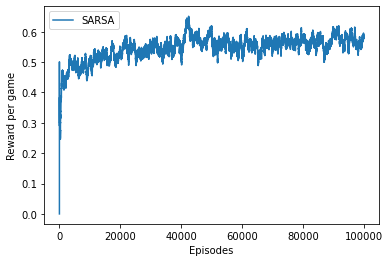

In [7]:
# Reward per game using an exponential average with 500 decay.
R_ma_s = pd.DataFrame({'R': R_save_sarsa}).ewm(com=400).mean()

plt.plot(R_ma_s, label="SARSA")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Reward per game")
plt.savefig(f"s_rewards_{N_episodes}.pdf")

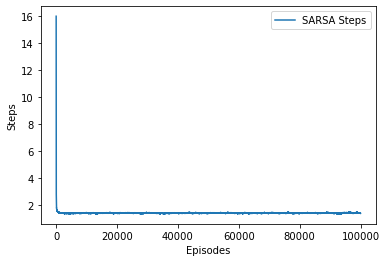

In [8]:
# Reward per game using an exponential average with 500 decay.
N_ma_s = pd.DataFrame({'N': N_moves_save_sarsa}).ewm(com=400).mean()
plt.plot(N_ma_s, label="SARSA Steps")
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.legend()
plt.savefig(f"s_steps_{N_episodes}.pdf")